In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
import molvs
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/PMDM
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from PMDM

Read the smi data to list and check if they are valid molecules or not

and also standardize them:

In [4]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [5]:
smi_list = []
with open('PMDM_10000.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing", unit="mol"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

len(standardized_smiles_list)

Standardizing:  21%|██▏       | 2079/9757 [13:00<1:46:04,  1.21mol/s][13:21:41] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:21:41] Explicit valence for atom # 15 C, 5, is greater than permitted
Standardizing:  62%|██████▏   | 6018/9757 [32:02<54:25,  1.14mol/s]  [13:40:43] Explicit valence for atom # 16 N, 4, is greater than permitted
[13:40:43] Explicit valence for atom # 5 N, 4, is greater than permitted
Standardizing:  75%|███████▌  | 7327/9757 [40:53<45:08,  1.11s/mol][13:49:34] Explicit valence for atom # 8 N, 4, is greater than permitted
[13:49:34] Explicit valence for atom # 1 N, 4, is greater than permitted
Standardizing:  77%|███████▋  | 7544/9757 [42:23<06:01,  6.12mol/s][13:51:04] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:51:05] Explicit valence for atom # 6 C, 5, is greater than permitted
Standardizing:  98%|█████████▊| 9538/9757 [52:26<01:06,  3.28mol/s][14:01:07] Explicit valence for atom # 4 N, 4, is greater than permitted
[

9612

In [6]:
with open('PMDM_10000_standardized.smi', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

Read the smi file generate from PMDM: 10 molecules for receptors in each test set/

In [7]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

SMILES
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...
3                   NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...
...                                                 ...
9607  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...
9608                         OC1CC2CC3=CC=CC=CC3CC2CC1O
9609  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...
9610  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...
9611  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...

[9612 rows x 1 columns]

Add an RDKit molecule to the dataframe

In [8]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)
df

SMILES  \
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO   
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O   
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
3                   NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21   
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...   
...                                                 ...   
9607  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...   
9608                         OC1CC2CC3=CC=CC=CC3CC2CC1O   
9609  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...   
9610  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...   
9611  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...   

                                                   mol  
0     <rdkit.Chem.rdchem.Mol object at 0x7bad382b9c40>  
1     <rdkit.Chem.rdchem.Mol object at 0x7bad382bb140>  
2     <rdkit.Chem.rdchem.Mol object at 0x7bad382b9850>  
3     <rdkit.Chem.rdchem.Mol object at 0x7bad382b9700>  
4     <rdkit.Chem.rdchem.Mol object at 0x7bad382ba570>  
...                                                ...  
9607  <rdkit.Chem.rdchem.Mol object at 0x7bad36d67bc0>  
9608  <rdkit.Chem.rdchem.Mol object at 0x7bad36d67c30>  
9609  <rdkit.Chem.rdchem.Mol object at 0x7bad36d67ca0>  
9610  <rdkit.Chem.rdchem.Mol object at 0x7bad36d67d10>  
9611  <rdkit.Chem.rdchem.Mol object at 0x7bad36d67d80>  

[9612 rows x 2 columns]

Strip salts from the molecule

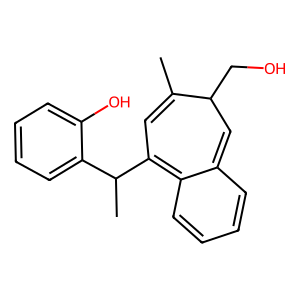

In [9]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [10]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                          [C1=CCC=c2ccccc2=C1, c1ccccc1]
1                                    [O=c1cccc2c(c1)CNC2]
2                              [C=C1CCCCC1, O=C1CCCCCCC1]
3                       [c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3]
4       [N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, C1=CCC...
                              ...                        
9607    [O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2...
9608                           [C1=CC=C2CC3CCCCC3CC2C=C1]
9609      [O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23]
9610    [O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O...
9611    [O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5...
Name: ring_sytems, Length: 9612, dtype: object

In [11]:
df.ring_sytems.values

array([list(['C1=CCC=c2ccccc2=C1', 'c1ccccc1']),
       list(['O=c1cccc2c(c1)CNC2']), list(['C=C1CCCCC1', 'O=C1CCCCCCC1']),
       ..., list(['O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23']),
       list(['O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O)O[PH]2(=O)=O']),
       list(['O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5nc(=O)c(cc5c4cc2)CC1C3'])],
      dtype=object)

See how many times each ring system occurs

In [12]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

SMILES  Count
1                               c1ccccc1   2678
49                          C1=CC=CCC=C1    797
20                               C1CCCC1    444
12                              c1ccncc1    367
266                          C1CC2CCC1C2    194
...                                  ...    ...
2440             C1CN2CCC3(CC2)CN[C@H]13      1
2438  C1=CC=C2CC3CC4=C(C=CC=CC4)C3C2C=C1      1
2437             O=C1c2ccccc2CCc2ccccc21      1
2436                  C1=Cc2cc[nH]c2OCC1      1
2450     C1=CC2=C(C=CC1)C1CCC[C@@H]1C=C2      1

[6307 rows x 2 columns]

View the ring system frequencies

In [13]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [15]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

[15:23:57] unrecognized chirality tag (7) on atom 0 is ignored.
[15:23:57] unrecognized chirality tag (7) on atom 0 is ignored.


In [16]:
res

0          [(C1=CCC=c2ccccc2=C1, 0), (c1ccccc1, 2568039)]
1                               [(O=c1cccc2c(c1)CNC2, 0)]
2                 [(C=C1CCCCC1, 672), (O=C1CCCCCCC1, 12)]
3                  [(c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3, 0)]
4       [(N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, 0), (...
                              ...                        
9607    [(O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C...
9608                      [(C1=CC=C2CC3CCCCC3CC2C=C1, 0)]
9609    [(O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc2...
9610    [(O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=...
9611    [(O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c...
Name: mol, Length: 9612, dtype: object

In [17]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO   
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O   
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
3                   NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21   
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...   
...                                                 ...   
9607  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...   
9608                         OC1CC2CC3=CC=CC=CC3CC2CC1O   
9609  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...   
9610  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...   
9611  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c4a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c510>   
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
3     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c5f0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c900>   
...                                                ...   
9607  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9000>   
9608  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9070>   
9609  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb90e0>   
9610  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9150>   
9611  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb91c0>   

                                            ring_sytems  \
0                        [C1=CCC=c2ccccc2=C1, c1ccccc1]   
1                                  [O=c1cccc2c(c1)CNC2]   
2                            [C=C1CCCCC1, O=C1CCCCCCC1]   
3                     [c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3]   
4     [N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, C1=CCC...   
...                                                 ...   
9607  [O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2...   
9608                         [C1=CC=C2CC3CCCCC3CC2C=C1]   
9609    [O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23]   
9610  [O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O...   
9611  [O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5...   

                                               min_ring min_freq  
0                                    C1=CCC=c2ccccc2=C1        0  
1                                    O=c1cccc2c(c1)CNC2        0  
2                                          O=C1CCCCCCC1       12  
3                       c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3        0  
4                 N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12        0  
...                                                 ...      ...  
9607  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2)...        0  
9608                           C1=CC=C2CC3CCCCC3CC2C=C1        0  
9609      O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23        0  
9610  O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O)...        0  
9611  O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5n...        0  

[9612 rows x 5 columns]

Visualize molecules that has a ring occurence = 0

In [18]:
df_ring_appearance_0 = df[df.min_freq == 0]
df_ring_appearance_0

SMILES  \
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO   
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O   
3                   NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21   
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...   
5                Oc1ccc2c(c1O)CCC1C(O)C3=C(OC=CC=C3)C21   
...                                                 ...   
9607  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...   
9608                         OC1CC2CC3=CC=CC=CC3CC2CC1O   
9609  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...   
9610  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...   
9611  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c4a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c510>   
3     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c5f0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c900>   
5     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c660>   
...                                                ...   
9607  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9000>   
9608  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9070>   
9609  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb90e0>   
9610  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9150>   
9611  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb91c0>   

                                            ring_sytems  \
0                        [C1=CCC=c2ccccc2=C1, c1ccccc1]   
1                                  [O=c1cccc2c(c1)CNC2]   
3                     [c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3]   
4     [N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, C1=CCC...   
5                     [C1=COC2=C(C=C1)CC1CCc3ccccc3C21]   
...                                                 ...   
9607  [O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2...   
9608                         [C1=CC=C2CC3CCCCC3CC2C=C1]   
9609    [O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23]   
9610  [O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O...   
9611  [O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5...   

                                               min_ring min_freq  
0                                    C1=CCC=c2ccccc2=C1        0  
1                                    O=c1cccc2c(c1)CNC2        0  
3                       c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3        0  
4                 N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12        0  
5                       C1=COC2=C(C=C1)CC1CCc3ccccc3C21        0  
...                                                 ...      ...  
9607  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2)...        0  
9608                           C1=CC=C2CC3CCCCC3CC2C=C1        0  
9609      O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23        0  
9610  O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O)...        0  
9611  O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5n...        0  

[5950 rows x 5 columns]

In [19]:
df_ring_appearance_0['SMILES'].to_csv('PMDM_1000_control_ring_appearance_0_100.smi',index=False,header=False)

In [20]:
df_ring_appearance_100more = df[df.min_freq > 100]
df_ring_appearance_100more

SMILES  \
8     O=C(c1cnc(O[PH](=O)(=O)O)c(O)c1)c1ccc(O)cn1   
9                      O=C(O)NC1CC(O)c2ccc(O)cc21   
19           O=[PH](=O)(O)[C@]1(O)COC(O)(O)C(O)C1   
25        O=C1C(O)C(O)C(c2cccc(C(O)CO)c2O)CC1(O)O   
28                  NC(=O)C(=O)NC(O)c1ccccc(=O)c1   
...                                           ...   
9541             N[C@]1(O)CCc2ccc(C(=O)O)c(O)c2C1   
9545                                    Oc1ccccc1   
9562                O=C(O)C1=C(CC2OCC(O)C2O)CC=C1   
9565             Fc1ccc(-c2ccccc2)c(OCc2ccccc2)c1   
9586                     Cc1cc2cnccc2cc1-c1ccccc1   

                                                   mol  \
8     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c430>   
9     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c2e0>   
19    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3cd60>   
25    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3cb30>   
28    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3cc80>   
...                                                ...   
9541  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7290>   
9545  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7450>   
9562  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7bc0>   
9565  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7d10>   
9586  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb86d0>   

                         ring_sytems          min_ring min_freq  
8               [c1ccncc1, c1ccncc1]          c1ccncc1   275595  
9                  [c1ccc2c(c1)CCC2]   c1ccc2c(c1)CCC2    10459  
19                        [C1CCOCC1]          C1CCOCC1    74445  
25            [O=C1CCCCC1, c1ccccc1]        O=C1CCCCC1      862  
28                     [O=c1cccccc1]       O=c1cccccc1      515  
...                              ...               ...      ...  
9541              [c1ccc2c(c1)CCCC2]  c1ccc2c(c1)CCCC2    10254  
9545                      [c1ccccc1]          c1ccccc1  2568039  
9562            [C1=CCC=C1, C1CCOC1]         C1=CCC=C1      141  
9565  [c1ccccc1, c1ccccc1, c1ccccc1]          c1ccccc1  2568039  
9586      [c1ccc2cnccc2c1, c1ccccc1]    c1ccc2cnccc2c1     7830  

[2082 rows x 5 columns]

In [21]:
df_ring_appearance_100more['SMILES'].to_csv('PMDM_1000_control_ring_appearance_100more_100.smi',index=False,header=False)

In [22]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [23]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Accepted unusual valence(s): P(6); Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Accepted unusual valence(s): P(6)

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Accepted unusual valence(s): P(6)

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Accepted unusual valence(s): P(6); Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined stereo

[15:24:23] WARNING: Omitted undefined 

SMILES  \
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO   
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O   
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
3                   NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21   
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...   
...                                                 ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...   
9259                         OC1CC2CC3=CC=CC=CC3CC2CC1O   
9260  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...   
9261  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...   
9262  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c4a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c510>   
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
3     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c5f0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c900>   
...                                                ...   
9258  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9000>   
9259  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9070>   
9260  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb90e0>   
9261  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9150>   
9262  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb91c0>   

                                            ring_sytems  \
0                        [C1=CCC=c2ccccc2=C1, c1ccccc1]   
1                                  [O=c1cccc2c(c1)CNC2]   
2                            [C=C1CCCCC1, O=C1CCCCCCC1]   
3                     [c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3]   
4     [N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, C1=CCC...   
...                                                 ...   
9258  [O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2...   
9259                         [C1=CC=C2CC3CCCCC3CC2C=C1]   
9260    [O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23]   
9261  [O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O...   
9262  [O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5...   

                                               min_ring min_freq  \
0                                    C1=CCC=c2ccccc2=C1        0   
1                                    O=c1cccc2c(c1)CNC2        0   
2                                          O=C1CCCCCCC1       12   
3                       c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3        0   
4                 N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12        0   
...                                                 ...      ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2)...        0   
9259                           C1=CC=C2CC3CCCCC3CC2C=C1        0   
9260      O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23        0   
9261  O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O)...        0   
9262  O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5n...        0   

                                                  inchi  
0     InChI=1S/C21H22O2/c1-14-11-20(15(2)18-8-5-6-10...  
1     InChI=1S/C10H9NO6/c12-7-3-5-6(2-1-4(7)9(14)15)...  
2     InChI=1S/C17H24O12P/c18-10-1-2-12(13(20)5-11(1...  
3     InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...  
4     InChI=1S/C22H30N2O4/c1-14-19(26)6-3-10-22(14)1...  
...                                                 ...  
9258  InChI=1S/C24H15NO6/c26-19-9-16-12-7-17-14(21(1...  
9259  InChI=1S/C15H20O2/c16-14-8-12-6-10-4-2-1-3-5-1...  
9260  InChI=1S/C25H27N3O3/c1-14-25(31)19-10-18-17(11...  
9261  InChI=1S/C15H19NO9P2/c1-8-9-5-12(14(18)16-7-9)...  
9262  InChI=1S/C28H20N2O5/c31-22-8-14-5-6-28-11-15(1...  

[9263 rows x 6 columns]

How many molecules have ring system?

In [24]:
df_ring = df[df.min_freq != -1]
df_ring

SMILES  \
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO   
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O   
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
3                   NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21   
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...   
...                                                 ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...   
9259                         OC1CC2CC3=CC=CC=CC3CC2CC1O   
9260  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...   
9261  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...   
9262  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c4a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c510>   
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
3     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c5f0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c900>   
...                                                ...   
9258  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9000>   
9259  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9070>   
9260  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb90e0>   
9261  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9150>   
9262  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb91c0>   

                                            ring_sytems  \
0                        [C1=CCC=c2ccccc2=C1, c1ccccc1]   
1                                  [O=c1cccc2c(c1)CNC2]   
2                            [C=C1CCCCC1, O=C1CCCCCCC1]   
3                     [c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3]   
4     [N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, C1=CCC...   
...                                                 ...   
9258  [O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2...   
9259                         [C1=CC=C2CC3CCCCC3CC2C=C1]   
9260    [O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23]   
9261  [O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O...   
9262  [O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5...   

                                               min_ring min_freq  \
0                                    C1=CCC=c2ccccc2=C1        0   
1                                    O=c1cccc2c(c1)CNC2        0   
2                                          O=C1CCCCCCC1       12   
3                       c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3        0   
4                 N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12        0   
...                                                 ...      ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2)...        0   
9259                           C1=CC=C2CC3CCCCC3CC2C=C1        0   
9260      O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23        0   
9261  O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O)...        0   
9262  O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5n...        0   

                                                  inchi  
0     InChI=1S/C21H22O2/c1-14-11-20(15(2)18-8-5-6-10...  
1     InChI=1S/C10H9NO6/c12-7-3-5-6(2-1-4(7)9(14)15)...  
2     InChI=1S/C17H24O12P/c18-10-1-2-12(13(20)5-11(1...  
3     InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...  
4     InChI=1S/C22H30N2O4/c1-14-19(26)6-3-10-22(14)1...  
...                                                 ...  
9258  InChI=1S/C24H15NO6/c26-19-9-16-12-7-17-14(21(1...  
9259  InChI=1S/C15H20O2/c16-14-8-12-6-10-4-2-1-3-5-1...  
9260  InChI=1S/C25H27N3O3/c1-14-25(31)19-10-18-17(11...  
9261  InChI=1S/C15H19NO9P2/c1-8-9-5-12(14(18)16-7-9)...  
9262  InChI=1S/C28H20N2O5/c31-22-8-14-5-6-28-11-15(1...  

[9099 rows x 6 columns]

In [25]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

SMILES  \
8     O=C(c1cnc(O[PH](=O)(=O)O)c(O)c1)c1ccc(O)cn1   
9                      O=C(O)NC1CC(O)c2ccc(O)cc21   
19           O=[PH](=O)(O)[C@]1(O)COC(O)(O)C(O)C1   
25        O=C1C(O)C(O)C(c2cccc(C(O)CO)c2O)CC1(O)O   
28                  NC(=O)C(=O)NC(O)c1ccccc(=O)c1   
...                                           ...   
9191              O=C(O)CC1CCNC([PH](=O)(=O)O)CC1   
9196             N[C@]1(O)CCc2ccc(C(=O)O)c(O)c2C1   
9216                O=C(O)C1=C(CC2OCC(O)C2O)CC=C1   
9219             Fc1ccc(-c2ccccc2)c(OCc2ccccc2)c1   
9239                     Cc1cc2cnccc2cc1-c1ccccc1   

                                                   mol  \
8     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c430>   
9     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c2e0>   
19    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3cd60>   
25    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3cb30>   
28    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3cc80>   
...                                                ...   
9191  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7060>   
9196  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7290>   
9216  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7bc0>   
9219  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7d10>   
9239  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb86d0>   

                         ring_sytems          min_ring min_freq  \
8               [c1ccncc1, c1ccncc1]          c1ccncc1   275595   
9                  [c1ccc2c(c1)CCC2]   c1ccc2c(c1)CCC2    10459   
19                        [C1CCOCC1]          C1CCOCC1    74445   
25            [O=C1CCCCC1, c1ccccc1]        O=C1CCCCC1      862   
28                     [O=c1cccccc1]       O=c1cccccc1      515   
...                              ...               ...      ...   
9191                     [C1CCCNCC1]         C1CCCNCC1     8296   
9196              [c1ccc2c(c1)CCCC2]  c1ccc2c(c1)CCCC2    10254   
9216            [C1=CCC=C1, C1CCOC1]         C1=CCC=C1      141   
9219  [c1ccccc1, c1ccccc1, c1ccccc1]          c1ccccc1  2568039   
9239      [c1ccc2cnccc2c1, c1ccccc1]    c1ccc2cnccc2c1     7830   

                                                  inchi  
8     InChI=1S/C11H8N2O7P/c14-7-1-2-8(12-5-7)10(16)6...  
9     InChI=1S/C10H11NO4/c12-5-1-2-6-7(3-5)8(4-9(6)1...  
19    InChI=1S/C5H10O8P/c6-3-1-4(7,14(10,11)12)2-13-...  
25    InChI=1S/C14H18O8/c15-5-9(16)7-3-1-2-6(10(7)17...  
28    InChI=1S/C10H10N2O4/c11-8(14)10(16)12-9(15)6-3...  
...                                                 ...  
9191  InChI=1S/C8H15NO5P/c10-8(11)5-6-1-2-7(9-4-3-6)...  
9196  InChI=1S/C11H13NO4/c12-11(16)4-3-6-1-2-7(10(14...  
9216  InChI=1S/C11H14O5/c12-8-5-16-9(10(8)13)4-6-2-1...  
9219  InChI=1S/C19H15FO/c20-17-11-12-18(16-9-5-2-6-1...  
9239  InChI=1S/C16H13N/c1-12-9-15-11-17-8-7-14(15)10...  

[1849 rows x 6 columns]

### How many of them could pass PAINS filter?

Get a list of rules

In [26]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [27]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [28]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [29]:
reos.pandas_mols(df.mol)

  0%|          | 0/9263 [00:00<?, ?it/s]

rule_set_name     description
0               ok              ok
1               ok              ok
2               ok              ok
3            PAINS  mannich_A(296)
4               ok              ok
...            ...             ...
9258            ok              ok
9259            ok              ok
9260            ok              ok
9261            ok              ok
9262            ok              ok

[9263 rows x 2 columns]

In [30]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/9263 [00:00<?, ?it/s]

SMILES  \
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO   
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O   
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...   
7     O=C(O)c1cccc(C2c3ccccc3C3CC4C(=O)NC(O)(O)NC4CC...   
...                                                 ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...   
9259                         OC1CC2CC3=CC=CC=CC3CC2CC1O   
9260  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...   
9261  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...   
9262  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c4a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c510>   
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
4     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c900>   
7     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c120>   
...                                                ...   
9258  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9000>   
9259  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9070>   
9260  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb90e0>   
9261  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9150>   
9262  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb91c0>   

                                            ring_sytems  \
0                        [C1=CCC=c2ccccc2=C1, c1ccccc1]   
1                                  [O=c1cccc2c(c1)CNC2]   
2                            [C=C1CCCCC1, O=C1CCCCCCC1]   
4     [N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, C1=CCC...   
7               [c1ccccc1, O=C1NCNC2CC3Cc4ccccc4C3CC12]   
...                                                 ...   
9258  [O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2...   
9259                         [C1=CC=C2CC3CCCCC3CC2C=C1]   
9260    [O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23]   
9261  [O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O...   
9262  [O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5...   

                                               min_ring min_freq  \
0                                    C1=CCC=c2ccccc2=C1        0   
1                                    O=c1cccc2c(c1)CNC2        0   
2                                          O=C1CCCCCCC1       12   
4                 N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12        0   
7                           O=C1NCNC2CC3Cc4ccccc4C3CC12        0   
...                                                 ...      ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2)...        0   
9259                           C1=CC=C2CC3CCCCC3CC2C=C1        0   
9260      O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23        0   
9261  O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O)...        0   
9262  O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5n...        0   

                                                  inchi rule_set_name  \
0     InChI=1S/C21H22O2/c1-14-11-20(15(2)18-8-5-6-10...            ok   
1     InChI=1S/C10H9NO6/c12-7-3-5-6(2-1-4(7)9(14)15)...            ok   
2     InChI=1S/C17H24O12P/c18-10-1-2-12(13(20)5-11(1...            ok   
4     InChI=1S/C22H30N2O4/c1-14-19(26)6-3-10-22(14)1...            ok   
7     InChI=1S/C22H22N2O5/c25-20-17-9-15-13-6-1-2-7-...            ok   
...                                                 ...           ...   
9258  InChI=1S/C24H15NO6/c26-19-9-16-12-7-17-14(21(1...            ok   
9259  InChI=1S/C15H20O2/c16-14-8-12-6-10-4-2-1-3-5-1...            ok   
9260  InChI=1S/C25H27N3O3/c1-14-25(31)19-10-18-17(11...            ok   
9261  InChI=1S/C15H19NO9P2/c1-8-9-5-12(14(18)16-7-9)...            ok   
9262  InChI=1S/C28H20N2O5/c31-22-8-14-5-6-28-11-15(1...            ok   

     description  
0             ok  
1             ok  
2             ok  
4             ok  
7             ok  
...          ...  
9258          ok  
9259          ok  
9260          ok  
9261          ok  
9262          ok  

[8606 rows 

Test all filters from rd_filter:

In [31]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/9263 [00:00<?, ?it/s]

Glaxo 0.9214077512684875 ['Glaxo'] 8535


  0%|          | 0/9263 [00:00<?, ?it/s]

Dundee 0.4563316420166253 ['Dundee'] 4227


  0%|          | 0/9263 [00:00<?, ?it/s]

BMS 0.7459786246356472 ['BMS'] 6910


  0%|          | 0/9263 [00:00<?, ?it/s]

SureChEMBL 0.7973658641908669 ['SureChEMBL'] 7386


  0%|          | 0/9263 [00:00<?, ?it/s]

MLSMR 0.5317931555651517 ['MLSMR'] 4926


  0%|          | 0/9263 [00:00<?, ?it/s]

Inpharmatica 0.7296772104069956 ['Inpharmatica'] 6759


  0%|          | 0/9263 [00:00<?, ?it/s]

LINT 0.7146712728057865 ['LINT'] 6620


### How many of them could pass filters suggested by Dr.Reymond?

In [32]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

SMILES  \
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO   
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O   
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
3                   NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21   
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...   
...                                                 ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...   
9259                         OC1CC2CC3=CC=CC=CC3CC2CC1O   
9260  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...   
9261  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...   
9262  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c4a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c510>   
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
3     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c5f0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c900>   
...                                                ...   
9258  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9000>   
9259  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9070>   
9260  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb90e0>   
9261  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9150>   
9262  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb91c0>   

                                            ring_sytems  \
0                        [C1=CCC=c2ccccc2=C1, c1ccccc1]   
1                                  [O=c1cccc2c(c1)CNC2]   
2                            [C=C1CCCCC1, O=C1CCCCCCC1]   
3                     [c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3]   
4     [N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, C1=CCC...   
...                                                 ...   
9258  [O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2...   
9259                         [C1=CC=C2CC3CCCCC3CC2C=C1]   
9260    [O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23]   
9261  [O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O...   
9262  [O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5...   

                                               min_ring min_freq  \
0                                    C1=CCC=c2ccccc2=C1        0   
1                                    O=c1cccc2c(c1)CNC2        0   
2                                          O=C1CCCCCCC1       12   
3                       c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3        0   
4                 N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12        0   
...                                                 ...      ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2)...        0   
9259                           C1=CC=C2CC3CCCCC3CC2C=C1        0   
9260      O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23        0   
9261  O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O)...        0   
9262  O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5n...        0   

                                                  inchi  Reymond  
0     InChI=1S/C21H22O2/c1-14-11-20(15(2)18-8-5-6-10...     True  
1     InChI=1S/C10H9NO6/c12-7-3-5-6(2-1-4(7)9(14)15)...     True  
2     InChI=1S/C17H24O12P/c18-10-1-2-12(13(20)5-11(1...     True  
3     InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...     True  
4     InChI=1S/C22H30N2O4/c1-14-19(26)6-3-10-22(14)1...     True  
...                                                 ...      ...  
9258  InChI=1S/C24H15NO6/c26-19-9-16-12-7-17-14(21(1...     True  
9259  InChI=1S/C15H20O2/c16-14-8-12-6-10-4-2-1-3-5-1...     True  
9260  InChI=1S/C25H27N3O3/c1-14-25(31)19-10-18-17(11...     True  
9261  InChI=1S/C15H19NO9P2/c1-8-9-5-12(14(18)16-7-9)...     True  
9262  InChI=1S/C28H20N2O5/c31-22-8-14-5-6-28-11-15(1...     True  

[9263 rows x 7 columns]

In [33]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

SMILES  \
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO   
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O   
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
3                   NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21   
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...   
...                                                 ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...   
9259                         OC1CC2CC3=CC=CC=CC3CC2CC1O   
9260  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...   
9261  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...   
9262  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c4a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c510>   
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
3     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c5f0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c900>   
...                                                ...   
9258  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9000>   
9259  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9070>   
9260  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb90e0>   
9261  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9150>   
9262  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb91c0>   

                                            ring_sytems  \
0                        [C1=CCC=c2ccccc2=C1, c1ccccc1]   
1                                  [O=c1cccc2c(c1)CNC2]   
2                            [C=C1CCCCC1, O=C1CCCCCCC1]   
3                     [c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3]   
4     [N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, C1=CCC...   
...                                                 ...   
9258  [O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2...   
9259                         [C1=CC=C2CC3CCCCC3CC2C=C1]   
9260    [O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23]   
9261  [O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O...   
9262  [O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5...   

                                               min_ring min_freq  \
0                                    C1=CCC=c2ccccc2=C1        0   
1                                    O=c1cccc2c(c1)CNC2        0   
2                                          O=C1CCCCCCC1       12   
3                       c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3        0   
4                 N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12        0   
...                                                 ...      ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2)...        0   
9259                           C1=CC=C2CC3CCCCC3CC2C=C1        0   
9260      O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23        0   
9261  O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O)...        0   
9262  O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5n...        0   

                                                  inchi  Reymond  
0     InChI=1S/C21H22O2/c1-14-11-20(15(2)18-8-5-6-10...     True  
1     InChI=1S/C10H9NO6/c12-7-3-5-6(2-1-4(7)9(14)15)...     True  
2     InChI=1S/C17H24O12P/c18-10-1-2-12(13(20)5-11(1...     True  
3     InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...     True  
4     InChI=1S/C22H30N2O4/c1-14-19(26)6-3-10-22(14)1...     True  
...                                                 ...      ...  
9258  InChI=1S/C24H15NO6/c26-19-9-16-12-7-17-14(21(1...     True  
9259  InChI=1S/C15H20O2/c16-14-8-12-6-10-4-2-1-3-5-1...     True  
9260  InChI=1S/C25H27N3O3/c1-14-25(31)19-10-18-17(11...     True  
9261  InChI=1S/C15H19NO9P2/c1-8-9-5-12(14(18)16-7-9)...     True  
9262  InChI=1S/C28H20N2O5/c31-22-8-14-5-6-28-11-15(1...     True  

[9167 rows x 7 columns]

### How many of them could pass RO5?

In [34]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

SMILES  \
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO   
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O   
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
3                   NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21   
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...   
...                                                 ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...   
9259                         OC1CC2CC3=CC=CC=CC3CC2CC1O   
9260  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...   
9261  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...   
9262  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c4a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c510>   
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
3     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c5f0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c900>   
...                                                ...   
9258  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9000>   
9259  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9070>   
9260  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb90e0>   
9261  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9150>   
9262  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb91c0>   

                                            ring_sytems  \
0                        [C1=CCC=c2ccccc2=C1, c1ccccc1]   
1                                  [O=c1cccc2c(c1)CNC2]   
2                            [C=C1CCCCC1, O=C1CCCCCCC1]   
3                     [c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3]   
4     [N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, C1=CCC...   
...                                                 ...   
9258  [O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2...   
9259                         [C1=CC=C2CC3CCCCC3CC2C=C1]   
9260    [O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23]   
9261  [O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O...   
9262  [O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5...   

                                               min_ring min_freq  \
0                                    C1=CCC=c2ccccc2=C1        0   
1                                    O=c1cccc2c(c1)CNC2        0   
2                                          O=C1CCCCCCC1       12   
3                       c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3        0   
4                 N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12        0   
...                                                 ...      ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2)...        0   
9259                           C1=CC=C2CC3CCCCC3CC2C=C1        0   
9260      O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23        0   
9261  O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O)...        0   
9262  O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5n...        0   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C21H22O2/c1-14-11-20(15(2)18-8-5-6-10...     True      True  
1     InChI=1S/C10H9NO6/c12-7-3-5-6(2-1-4(7)9(14)15)...     True      True  
2     InChI=1S/C17H24O12P/c18-10-1-2-12(13(20)5-11(1...     True     False  
3     InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...     True      True  
4     InChI=1S/C22H30N2O4/c1-14-19(26)6-3-10-22(14)1...     True      True  
...                                                 ...      ...       ...  
9258  InChI=1S/C24H15NO6/c26-19-9-16-12-7-17-14(21(1...     True      True  
9259  InChI=1S/C15H20O2/c16-14-8-12-6-10-4-2-1-3-5-1...     True      True  
9260  InChI=1S/C25H27N3O3/c1-14-25(31)19-10-18-17(11...     True      True  
9261  InChI=1S/C15H19NO9P2/c1-8-9-5-12(14(18)16-7-9)...     True      True  
9262  InChI=1S/C28H20N2O5/c31-22-8-14-5-6-28-11-15(1...     True      True  

[9263 rows x 8 columns]

In [35]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

SMILES  \
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO   
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O   
3                   NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21   
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...   
5                Oc1ccc2c(c1O)CCC1C(O)C3=C(OC=CC=C3)C21   
...                                                 ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...   
9259                         OC1CC2CC3=CC=CC=CC3CC2CC1O   
9260  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...   
9261  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...   
9262  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c4a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c510>   
3     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c5f0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c900>   
5     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c660>   
...                                                ...   
9258  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9000>   
9259  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9070>   
9260  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb90e0>   
9261  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9150>   
9262  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb91c0>   

                                            ring_sytems  \
0                        [C1=CCC=c2ccccc2=C1, c1ccccc1]   
1                                  [O=c1cccc2c(c1)CNC2]   
3                     [c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3]   
4     [N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, C1=CCC...   
5                     [C1=COC2=C(C=C1)CC1CCc3ccccc3C21]   
...                                                 ...   
9258  [O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2...   
9259                         [C1=CC=C2CC3CCCCC3CC2C=C1]   
9260    [O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23]   
9261  [O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O...   
9262  [O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5...   

                                               min_ring min_freq  \
0                                    C1=CCC=c2ccccc2=C1        0   
1                                    O=c1cccc2c(c1)CNC2        0   
3                       c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3        0   
4                 N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12        0   
5                       C1=COC2=C(C=C1)CC1CCc3ccccc3C21        0   
...                                                 ...      ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2)...        0   
9259                           C1=CC=C2CC3CCCCC3CC2C=C1        0   
9260      O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23        0   
9261  O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O)...        0   
9262  O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5n...        0   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C21H22O2/c1-14-11-20(15(2)18-8-5-6-10...     True      True  
1     InChI=1S/C10H9NO6/c12-7-3-5-6(2-1-4(7)9(14)15)...     True      True  
3     InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...     True      True  
4     InChI=1S/C22H30N2O4/c1-14-19(26)6-3-10-22(14)1...     True      True  
5     InChI=1S/C17H16O4/c18-13-7-6-9-10(16(13)20)4-5...     True      True  
...                                                 ...      ...       ...  
9258  InChI=1S/C24H15NO6/c26-19-9-16-12-7-17-14(21(1...     True      True  
9259  InChI=1S/C15H20O2/c16-14-8-12-6-10-4-2-1-3-5-1...     True      True  
9260  InChI=1S/C25H27N3O3/c1-14-25(31)19-10-18-17(11...     True      True  
9261  InChI=1S/C15H19NO9P2/c1-8-9-5-12(14(18)16-7-9)...     True      True  
9262  InChI=1S/C28H20N2O5/c31-22-8-14-5-6-28-11-15(1...     True      True  

[7903 rows x 8 columns]

### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [36]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

[15:28:16] unrecognized chirality tag (7) on atom 0 is ignored.
[15:28:16] unrecognized chirality tag (7) on atom 0 is ignored.


0       [(C1=CCC=c2ccccc2=C1, 0), (c1ccccc1, 212435387...
1                               [(O=c1cccc2c(c1)CNC2, 0)]
2       [(C=C1CCCCC1, 135548184), (O=C1CCCCCCC1, 22044...
3                  [(c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3, 0)]
4       [(N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, 0), (...
                              ...                        
9258    [(O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C...
9259                      [(C1=CC=C2CC3CCCCC3CC2C=C1, 0)]
9260    [(O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc2...
9261    [(O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=...
9262    [(O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c...
Name: mol, Length: 9263, dtype: object

In [37]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO   
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O   
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
3                   NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21   
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...   
...                                                 ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...   
9259                         OC1CC2CC3=CC=CC=CC3CC2CC1O   
9260  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...   
9261  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...   
9262  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c4a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c510>   
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
3     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c5f0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c900>   
...                                                ...   
9258  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9000>   
9259  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9070>   
9260  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb90e0>   
9261  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9150>   
9262  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb91c0>   

                                            ring_sytems  \
0                        [C1=CCC=c2ccccc2=C1, c1ccccc1]   
1                                  [O=c1cccc2c(c1)CNC2]   
2                            [C=C1CCCCC1, O=C1CCCCCCC1]   
3                     [c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3]   
4     [N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, C1=CCC...   
...                                                 ...   
9258  [O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2...   
9259                         [C1=CC=C2CC3CCCCC3CC2C=C1]   
9260    [O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23]   
9261  [O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O...   
9262  [O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5...   

                                               min_ring min_freq  \
0                                    C1=CCC=c2ccccc2=C1        0   
1                                    O=c1cccc2c(c1)CNC2        0   
2                                          O=C1CCCCCCC1  2204496   
3                       c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3        0   
4                 N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12        0   
...                                                 ...      ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2)...        0   
9259                           C1=CC=C2CC3CCCCC3CC2C=C1        0   
9260      O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23        0   
9261  O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O)...        0   
9262  O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5n...        0   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C21H22O2/c1-14-11-20(15(2)18-8-5-6-10...     True      True  
1     InChI=1S/C10H9NO6/c12-7-3-5-6(2-1-4(7)9(14)15)...     True      True  
2     InChI=1S/C17H24O12P/c18-10-1-2-12(13(20)5-11(1...     True     False  
3     InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...     True      True  
4     InChI=1S/C22H30N2O4/c1-14-19(26)6-3-10-22(14)1...     True      True  
...                                                 ...      ...       ...  
9258  InChI=1S/C24H15NO6/c26-19-9-16-12-7-17-14(21(1...     True      True  
9259  InChI=1S/C15H20O2/c16-14-8-12-6-10-4-2-1-3-5-1...     True      True  
9260  InChI=1S/C25H27N3O3/c1-14-25(31)19-10-18-17(11...     True      True  
9261  InChI=1S/C15H19NO9P2/c1-8-9-5-12(14(18)16-7-9)...     True      True  
9262  InChI=1S/C28H20N2O5/c31-22-8-14-5-6-28-11-15(1...     True      True  

[9263 rows x 8 columns]

In [38]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [39]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
8           O=C(c1cnc(O[PH](=O)(=O)O)c(O)c1)c1ccc(O)cn1   
9                            O=C(O)NC1CC(O)c2ccc(O)cc21   
19                 O=[PH](=O)(O)[C@]1(O)COC(O)(O)C(O)C1   
23                       O=C1CCC(C2CC(O)c3ccccc32)CNC1O   
...                                                 ...   
9216                      O=C(O)C1=C(CC2OCC(O)C2O)CC=C1   
9219                   Fc1ccc(-c2ccccc2)c(OCc2ccccc2)c1   
9233                              CC1=C(C(=O)O)CC=CC=C1   
9238               O=c1nc2cc(O)cc(C3=CC=CCC=C3)c2c[nH]1   
9239                           Cc1cc2cnccc2cc1-c1ccccc1   

                                                   mol  \
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
8     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c430>   
9     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c2e0>   
19    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3cd60>   
23    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3ca50>   
...                                                ...   
9216  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7bc0>   
9219  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7d10>   
9233  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb83c0>   
9238  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb85f0>   
9239  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb86d0>   

                              ring_sytems             min_ring     min_freq  \
2              [C=C1CCCCC1, O=C1CCCCCCC1]         O=C1CCCCCCC1      2204496   
8                    [c1ccncc1, c1ccncc1]             c1ccncc1   9975620076   
9                       [c1ccc2c(c1)CCC2]      c1ccc2c(c1)CCC2    322454464   
19                             [C1CCOCC1]             C1CCOCC1   2751646430   
23         [O=C1CCCCNC1, c1ccc2c(c1)CCC2]          O=C1CCCCNC1        65806   
...                                   ...                  ...          ...   
9216                 [C1=CCC=C1, C1CCOC1]            C1=CCC=C1          212   
9219       [c1ccccc1, c1ccccc1, c1ccccc1]             c1ccccc1  21243538754   
9233                       [C1=CC=CCC=C1]         C1=CC=CCC=C1     31347662   
9238  [O=c1nc2ccccc2c[nH]1, C1=CC=CCC=C1]  O=c1nc2ccccc2c[nH]1       266370   
9239           [c1ccc2cnccc2c1, c1ccccc1]       c1ccc2cnccc2c1    138290300   

                                                  inchi  Reymond  Lipinski  
2     InChI=1S/C17H24O12P/c18-10-1-2-12(13(20)5-11(1...     True     False  
8     InChI=1S/C11H8N2O7P/c14-7-1-2-8(12-5-7)10(16)6...     True      True  
9     InChI=1S/C10H11NO4/c12-5-1-2-6-7(3-5)8(4-9(6)1...     True      True  
19    InChI=1S/C5H10O8P/c6-3-1-4(7,14(10,11)12)2-13-...     True      True  
23    InChI=1S/C15H19NO3/c17-13-6-5-9(8-16-15(13)19)...     True      True  
...                                                 ...      ...       ...  
9216  InChI=1S/C11H14O5/c12-8-5-16-9(10(8)13)4-6-2-1...     True      True  
9219  InChI=1S/C19H15FO/c20-17-11-12-18(16-9-5-2-6-1...     True     False  
9233  InChI=1S/C9H10O2/c1-7-5-3-2-4-6-8(7)9(10)11/h2...     True      True  
9238  InChI=1S/C15H12N2O2/c18-11-7-12(10-5-3-1-2-4-6...     True      True  
9239  InChI=1S/C16H13N/c1-12-9-15-11-17-8-7-14(15)10...     True      True  

[2541 rows x 8 columns]

In [40]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
8           O=C(c1cnc(O[PH](=O)(=O)O)c(O)c1)c1ccc(O)cn1   
9                            O=C(O)NC1CC(O)c2ccc(O)cc21   
19                 O=[PH](=O)(O)[C@]1(O)COC(O)(O)C(O)C1   
23                       O=C1CCC(C2CC(O)c3ccccc32)CNC1O   
...                                                 ...   
9216                      O=C(O)C1=C(CC2OCC(O)C2O)CC=C1   
9219                   Fc1ccc(-c2ccccc2)c(OCc2ccccc2)c1   
9233                              CC1=C(C(=O)O)CC=CC=C1   
9238               O=c1nc2cc(O)cc(C3=CC=CCC=C3)c2c[nH]1   
9239                           Cc1cc2cnccc2cc1-c1ccccc1   

                                                   mol  \
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
8     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c430>   
9     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c2e0>   
19    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3cd60>   
23    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3ca50>   
...                                                ...   
9216  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7bc0>   
9219  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7d10>   
9233  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb83c0>   
9238  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb85f0>   
9239  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb86d0>   

                              ring_sytems             min_ring     min_freq  \
2              [C=C1CCCCC1, O=C1CCCCCCC1]         O=C1CCCCCCC1      2204496   
8                    [c1ccncc1, c1ccncc1]             c1ccncc1   9975620076   
9                       [c1ccc2c(c1)CCC2]      c1ccc2c(c1)CCC2    322454464   
19                             [C1CCOCC1]             C1CCOCC1   2751646430   
23         [O=C1CCCCNC1, c1ccc2c(c1)CCC2]          O=C1CCCCNC1        65806   
...                                   ...                  ...          ...   
9216                 [C1=CCC=C1, C1CCOC1]            C1=CCC=C1          212   
9219       [c1ccccc1, c1ccccc1, c1ccccc1]             c1ccccc1  21243538754   
9233                       [C1=CC=CCC=C1]         C1=CC=CCC=C1     31347662   
9238  [O=c1nc2ccccc2c[nH]1, C1=CC=CCC=C1]  O=c1nc2ccccc2c[nH]1       266370   
9239           [c1ccc2cnccc2c1, c1ccccc1]       c1ccc2cnccc2c1    138290300   

                                                  inchi  Reymond  Lipinski  
2     InChI=1S/C17H24O12P/c18-10-1-2-12(13(20)5-11(1...     True     False  
8     InChI=1S/C11H8N2O7P/c14-7-1-2-8(12-5-7)10(16)6...     True      True  
9     InChI=1S/C10H11NO4/c12-5-1-2-6-7(3-5)8(4-9(6)1...     True      True  
19    InChI=1S/C5H10O8P/c6-3-1-4(7,14(10,11)12)2-13-...     True      True  
23    InChI=1S/C15H19NO3/c17-13-6-5-9(8-16-15(13)19)...     True      True  
...                                                 ...      ...       ...  
9216  InChI=1S/C11H14O5/c12-8-5-16-9(10(8)13)4-6-2-1...     True      True  
9219  InChI=1S/C19H15FO/c20-17-11-12-18(16-9-5-2-6-1...     True     False  
9233  InChI=1S/C9H10O2/c1-7-5-3-2-4-6-8(7)9(10)11/h2...     True      True  
9238  InChI=1S/C15H12N2O2/c18-11-7-12(10-5-3-1-2-4-6...     True      True  
9239  InChI=1S/C16H13N/c1-12-9-15-11-17-8-7-14(15)10...     True      True  

[3090 rows x 8 columns]

In [41]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
8           O=C(c1cnc(O[PH](=O)(=O)O)c(O)c1)c1ccc(O)cn1   
9                            O=C(O)NC1CC(O)c2ccc(O)cc21   
19                 O=[PH](=O)(O)[C@]1(O)COC(O)(O)C(O)C1   
23                       O=C1CCC(C2CC(O)c3ccccc32)CNC1O   
...                                                 ...   
9216                      O=C(O)C1=C(CC2OCC(O)C2O)CC=C1   
9219                   Fc1ccc(-c2ccccc2)c(OCc2ccccc2)c1   
9233                              CC1=C(C(=O)O)CC=CC=C1   
9238               O=c1nc2cc(O)cc(C3=CC=CCC=C3)c2c[nH]1   
9239                           Cc1cc2cnccc2cc1-c1ccccc1   

                                                   mol  \
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
8     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c430>   
9     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c2e0>   
19    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3cd60>   
23    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3ca50>   
...                                                ...   
9216  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7bc0>   
9219  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7d10>   
9233  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb83c0>   
9238  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb85f0>   
9239  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb86d0>   

                              ring_sytems             min_ring     min_freq  \
2              [C=C1CCCCC1, O=C1CCCCCCC1]         O=C1CCCCCCC1      2204496   
8                    [c1ccncc1, c1ccncc1]             c1ccncc1   9975620076   
9                       [c1ccc2c(c1)CCC2]      c1ccc2c(c1)CCC2    322454464   
19                             [C1CCOCC1]             C1CCOCC1   2751646430   
23         [O=C1CCCCNC1, c1ccc2c(c1)CCC2]          O=C1CCCCNC1        65806   
...                                   ...                  ...          ...   
9216                 [C1=CCC=C1, C1CCOC1]            C1=CCC=C1          212   
9219       [c1ccccc1, c1ccccc1, c1ccccc1]             c1ccccc1  21243538754   
9233                       [C1=CC=CCC=C1]         C1=CC=CCC=C1     31347662   
9238  [O=c1nc2ccccc2c[nH]1, C1=CC=CCC=C1]  O=c1nc2ccccc2c[nH]1       266370   
9239           [c1ccc2cnccc2c1, c1ccccc1]       c1ccc2cnccc2c1    138290300   

                                                  inchi  Reymond  Lipinski  
2     InChI=1S/C17H24O12P/c18-10-1-2-12(13(20)5-11(1...     True     False  
8     InChI=1S/C11H8N2O7P/c14-7-1-2-8(12-5-7)10(16)6...     True      True  
9     InChI=1S/C10H11NO4/c12-5-1-2-6-7(3-5)8(4-9(6)1...     True      True  
19    InChI=1S/C5H10O8P/c6-3-1-4(7,14(10,11)12)2-13-...     True      True  
23    InChI=1S/C15H19NO3/c17-13-6-5-9(8-16-15(13)19)...     True      True  
...                                                 ...      ...       ...  
9216  InChI=1S/C11H14O5/c12-8-5-16-9(10(8)13)4-6-2-1...     True      True  
9219  InChI=1S/C19H15FO/c20-17-11-12-18(16-9-5-2-6-1...     True     False  
9233  InChI=1S/C9H10O2/c1-7-5-3-2-4-6-8(7)9(10)11/h2...     True      True  
9238  InChI=1S/C15H12N2O2/c18-11-7-12(10-5-3-1-2-4-6...     True      True  
9239  InChI=1S/C16H13N/c1-12-9-15-11-17-8-7-14(15)10...     True      True  

[2765 rows x 8 columns]

### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [42]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

[15:28:34] unrecognized chirality tag (7) on atom 0 is ignored.
[15:28:34] unrecognized chirality tag (7) on atom 0 is ignored.


0        [(C1=CCC=c2ccccc2=C1, 0), (c1ccccc1, 503413992)]
1                               [(O=c1cccc2c(c1)CNC2, 0)]
2           [(C=C1CCCCC1, 439034), (O=C1CCCCCCC1, 48445)]
3                  [(c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3, 0)]
4       [(N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, 0), (...
                              ...                        
9258    [(O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C...
9259                      [(C1=CC=C2CC3CCCCC3CC2C=C1, 0)]
9260    [(O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc2...
9261    [(O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=...
9262    [(O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c...
Name: mol, Length: 9263, dtype: object

In [43]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0                  CC1=CC(C(C)c2ccccc2O)=c2ccccc2=CC1CO   
1                       O=C(O)c1ccc2c(cc1=O)C(O)NC2(O)O   
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
3                   NC1CC2C(CC3CC4CCC32CC4)c2cccc(O)c21   
4     CC1C(=O)C=CC[C@]12CC1C(=NCCC3C=CCC(O)C3)CCC(O)...   
...                                                 ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4c(O)c5cc(O)c(cc5cc...   
9259                         OC1CC2CC3=CC=CC=CC3CC2CC1O   
9260  CC1C(=O)c2cc3c(c(O)cc(N)c3cc2O)C2=CC=C(C=CC2)C...   
9261  CC1C2C=NC(=O)C(C2)C(=O)O[PH](=O)(=O)O[PH](=O)(...   
9262  O=C1CC(=O)[C@@]23C=Cc4cc(O)c(cc4C2)-c2ccc4[nH]...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c4a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c510>   
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
3     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c5f0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c900>   
...                                                ...   
9258  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9000>   
9259  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9070>   
9260  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb90e0>   
9261  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb9150>   
9262  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb91c0>   

                                            ring_sytems  \
0                        [C1=CCC=c2ccccc2=C1, c1ccccc1]   
1                                  [O=c1cccc2c(c1)CNC2]   
2                            [C=C1CCCCC1, O=C1CCCCCCC1]   
3                     [c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3]   
4     [N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12, C1=CCC...   
...                                                 ...   
9258  [O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2...   
9259                         [C1=CC=C2CC3CCCCC3CC2C=C1]   
9260    [O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23]   
9261  [O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O...   
9262  [O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5...   

                                               min_ring min_freq  \
0                                    C1=CCC=c2ccccc2=C1        0   
1                                    O=c1cccc2c(c1)CNC2        0   
2                                          O=C1CCCCCCC1    48445   
3                       c1ccc2c(c1)CCC1C2CC2CC3CCC21CC3        0   
4                 N=C1CCCN2C(=O)[C@@]3(CC=CC(=O)C3)CC12        0   
...                                                 ...      ...   
9258  O=C1Nc2ccc(c(=O)o2)C2Cc3ccc4cc5ccc(cc5cc4c3C2)...        0   
9259                           C1=CC=C2CC3CCCCC3CC2C=C1        0   
9260      O=C1CN2CCCC(NC2)C2=CC=C(CC=C2)c2cccc3ccc1cc23        0   
9261  O=C1CCCC2CC1CC1C=NC(=O)C(C1)C(=O)O[PH](=O)(=O)...        0   
9262  O=C1CC(=O)[C@@]23C=Cc4ccc(cc4C2)-c2ccc4[nH]c5n...        0   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C21H22O2/c1-14-11-20(15(2)18-8-5-6-10...     True      True  
1     InChI=1S/C10H9NO6/c12-7-3-5-6(2-1-4(7)9(14)15)...     True      True  
2     InChI=1S/C17H24O12P/c18-10-1-2-12(13(20)5-11(1...     True     False  
3     InChI=1S/C19H25NO/c20-16-10-15-14(13-2-1-3-17(...     True      True  
4     InChI=1S/C22H30N2O4/c1-14-19(26)6-3-10-22(14)1...     True      True  
...                                                 ...      ...       ...  
9258  InChI=1S/C24H15NO6/c26-19-9-16-12-7-17-14(21(1...     True      True  
9259  InChI=1S/C15H20O2/c16-14-8-12-6-10-4-2-1-3-5-1...     True      True  
9260  InChI=1S/C25H27N3O3/c1-14-25(31)19-10-18-17(11...     True      True  
9261  InChI=1S/C15H19NO9P2/c1-8-9-5-12(14(18)16-7-9)...     True      True  
9262  InChI=1S/C28H20N2O5/c31-22-8-14-5-6-28-11-15(1...     True      True  

[9263 rows x 8 columns]

In [44]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [45]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
2     O=C(O)C(C(=O)O[PH](=O)(=O)O)=C1CC(C2CCC(O)CC(O...   
8           O=C(c1cnc(O[PH](=O)(=O)O)c(O)c1)c1ccc(O)cn1   
9                            O=C(O)NC1CC(O)c2ccc(O)cc21   
19                 O=[PH](=O)(O)[C@]1(O)COC(O)(O)C(O)C1   
25              O=C1C(O)C(O)C(c2cccc(C(O)CO)c2O)CC1(O)O   
...                                                 ...   
9204   O=C(O)C1C/C=C(/C2OC(NCC3=CCC=CC=C3)CC2(O)O)CCCC1   
9219                   Fc1ccc(-c2ccccc2)c(OCc2ccccc2)c1   
9233                              CC1=C(C(=O)O)CC=CC=C1   
9238               O=c1nc2cc(O)cc(C3=CC=CCC=C3)c2c[nH]1   
9239                           Cc1cc2cnccc2cc1-c1ccccc1   

                                                   mol  \
2     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c580>   
8     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c430>   
9     <rdkit.Chem.rdchem.Mol object at 0x7bad36d3c2e0>   
19    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3cd60>   
25    <rdkit.Chem.rdchem.Mol object at 0x7bad36d3cb30>   
...                                                ...   
9204  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7680>   
9219  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb7d10>   
9233  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb83c0>   
9238  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb85f0>   
9239  <rdkit.Chem.rdchem.Mol object at 0x7bad36cb86d0>   

                                 ring_sytems             min_ring   min_freq  \
2                 [C=C1CCCCC1, O=C1CCCCCCC1]         O=C1CCCCCCC1      48445   
8                       [c1ccncc1, c1ccncc1]             c1ccncc1  110130832   
9                          [c1ccc2c(c1)CCC2]      c1ccc2c(c1)CCC2    5931219   
19                                [C1CCOCC1]             C1CCOCC1   27461873   
25                    [O=C1CCCCC1, c1ccccc1]           O=C1CCCCC1     506911   
...                                      ...                  ...        ...   
9204  [C1=C\CCCCCC/1, C1CCOC1, C1=CC=CCC=C1]        C1=C\CCCCCC/1        602   
9219          [c1ccccc1, c1ccccc1, c1ccccc1]             c1ccccc1  503413992   
9233                          [C1=CC=CCC=C1]         C1=CC=CCC=C1     321775   
9238     [O=c1nc2ccccc2c[nH]1, C1=CC=CCC=C1]  O=c1nc2ccccc2c[nH]1      33405   
9239              [c1ccc2cnccc2c1, c1ccccc1]       c1ccc2cnccc2c1    1540199   

                                                  inchi  Reymond  Lipinski  
2     InChI=1S/C17H24O12P/c18-10-1-2-12(13(20)5-11(1...     True     False  
8     InChI=1S/C11H8N2O7P/c14-7-1-2-8(12-5-7)10(16)6...     True      True  
9     InChI=1S/C10H11NO4/c12-5-1-2-6-7(3-5)8(4-9(6)1...     True      True  
19    InChI=1S/C5H10O8P/c6-3-1-4(7,14(10,11)12)2-13-...     True      True  
25    InChI=1S/C14H18O8/c15-5-9(16)7-3-1-2-6(10(7)17...     True     False  
...                                                 ...      ...       ...  
9204  InChI=1S/C21H29NO5/c23-20(24)17-10-6-5-9-16(11...     True      True  
9219  InChI=1S/C19H15FO/c20-17-11-12-18(16-9-5-2-6-1...     True     False  
9233  InChI=1S/C9H10O2/c1-7-5-3-2-4-6-8(7)9(10)11/h2...     True      True  
9238  InChI=1S/C15H12N2O2/c18-11-7-12(10-5-3-1-2-4-6...     True      True  
9239  InChI=1S/C16H13N/c1-12-9-15-11-17-8-7-14(15)10...     True      True  

[2137 rows x 8 columns]